In [1]:
import os, sys
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.aperture import CircularAperture, aperture_photometry
from tqdm import tqdm
import matplotlib, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cmcrameri import cm
np.random.seed(0)
# cosmology
from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

print("backend:", matplotlib.get_backend())
# interactive mode on
# %pylab widget

backend: module://matplotlib_inline.backend_inline


In [2]:
dir = "./data/calibrated"

# Common parameters
dir_image = os.path.join(dir, "cleanmap")

tbin = 60  # time binning in seconds
robust_mask = 0.0  # robust parameter for creating mask with continuum imaging. This mask is used for line imaging
nsigma_mask = 1.0  # noise threshold for creating mask. This mask is used for line imaging.


In [3]:
# plt.style.use('default')
# plt.style.use(['science', 'nature'])  # Other options: 'grid', 'ieee' (readable when printed in black and white), 'nature' (sans-serif fonts), 'scatter', 'notebook'. Note that this option take longer time to produce plots.
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Times New Roman'
# For ADC
plt.rcParams['pdf.fonttype'] = 42  # To embed fonts when saving as pdf
plt.rcParams['font.family'] = 'Liberation Serif'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['text.usetex'] = False  # Enable to use some special symbol in Italic font (e.g., theta)
plt.rcParams['font.size'] = 14  # This parameter control all text size, including title, x-axis and y-axis label, the x-axis and y-axis tick, legend, text, and annotation (default=10). We can change the font size for each element (e.g., title) using another code as followed.
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.direction'] = 'in'  # Change x-axis and y-axis tick direction (in/out/inout)
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0  # Adjust major and minor tick size
plt.rcParams['xtick.minor.size'] = 3.0  # Default is 3.5 and 2.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = 2.  # Adjust the line width of the axes (default is 0.8)
plt.rcParams['legend.handlelength'] = 1.2  # Adjust handle length
# plt.rcParams['legend.fancybox'] = False # 丸角
plt.rcParams['legend.framealpha'] = 0 # 透明度の指定、0で塗りつぶしなし
# plt.rcParams['legend.edgecolor'] = 'black' # edgeの色を変更
plt.rcParams['xtick.top'] = True            # 上部に目盛り線を描くかどうか
plt.rcParams['xtick.bottom'] = True         # 下部に目盛り線を描くかどうか
plt.rcParams['ytick.left'] = True           # 左部に目盛り線を描くかどうか
plt.rcParams['ytick.right'] = True          # 右部に目盛り線を描くかどうか

##### If need #####
# ax.xaxis.set_minor_locator(MultipleLocator(.5))  # To show the minor tick
# ax.yaxis.set_minor_locator(MultipleLocator(.5))
# plt.savefig('xxx.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

##### For colorblind-friendly colormap #####
# One of the safest solutions you can use to deal with color blind is to avoid using red and green together.
# https://towardsdatascience.com/matplotlib-styles-for-scientific-plotting-d023f74515b4


In [4]:
LINES_REST_MHZ = {
    r"o-H$_2$O$^+$": 1139541.5421,
    "HCN(13-12)": 1151449.088,
    "CO(10-9)":   1151985.452,
    r"H$_2$O(3$_{12}$-2$_{21}$)": 1153126.821,
    r"H$_2$O(3$_{21}$-2$_{12}$)": 1162911.602,
    r"H$_2$O(2$_{20}$-2$_{11}$)": 1228788.719,
    "HF(1-0)":    1232476.27,
}


In [5]:
def attach_cursor(ax, freq_obs, flux_mjy, z=6.024):
    """
    スペクトル(step)にカーソル追従の縦線と値表示を付ける。
    - freq_obs: 観測周波数[GHz] 1D
    - flux_mjy: フラックス[mJy]   1D（freq_obsと同長）
    """
    line = ax.axvline(freq_obs[0], ls=':', lw=1, color='k', alpha=0.6)
    dot, = ax.plot([freq_obs[0]], [flux_mjy[0]], marker='o', ms=4, mfc='none', mec='k', alpha=0.8)
    # 右上に情報ボックス
    info = ax.annotate(
        "", xy=(0.98, 0.98), xycoords="axes fraction",
        ha="right", va="top",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.6", alpha=0.9),
        fontsize=9
    )

    x = np.asarray(freq_obs)
    y = np.asarray(flux_mjy)

    def on_move(event):
        if event.inaxes is not ax:
            return
        # obs周波数に最も近い点へスナップ
        ix = int(np.argmin(np.abs(x - event.xdata)))
        xo, yo = x[ix], y[ix]
        xr = xo * (1.0 + z)  # rest [GHz]

        line.set_xdata([xo, xo])
        dot.set_data([xo], [yo])
        info.set_text(f"obs:  {xo:,.5f} GHz\nrest: {xr:,.2f} GHz (z={z})\nflux: {yo:,.3f} mJy")
        event.canvas.draw_idle()

    cid = ax.figure.canvas.mpl_connect('motion_notify_event', on_move)
    return {'line': line, 'dot': dot, 'info': info, 'cid': cid}

def estimate_rms_random_aperture(
    image, 
    aperture_mask, 
    n_mc=1000,
    sigma_clip_sigma=3.0,
    sigma_clip_iters=3,
    seed=None,
):
    """
    任意形状の2Dアパーチャマスク(0/1)をランダム平行移動して、アパーチャ和の分散からバックグラウンドRMSを推定する。
    - マスクは image と同解像度のピクセルスケールを想定（形状は同じでなくてもOK）
    - NaN を一つでも含む配置はスキップ
    """
    # --- 事前 σクリップ：明るい天体・アーチファクトをNaNに ---
    clipped = sigma_clip(image, sigma=sigma_clip_sigma, maxiters=sigma_clip_iters, cenfunc='median', masked=False, axis=(0,1)) # masked=Trueだとmasked arrayが帰ってきて、後々ややこしいのでここでnanにしてしまう
    ny, nx = image.shape
    cy, cx = ny // 2, nx // 2  # 画像の中心

    # --- マスクの有効画素（1の場所）の位置を取得 ---
    mask = np.asarray(aperture_mask, dtype=bool)
    yy, xx = np.nonzero(mask)
    # 中心基準に変換
    dyy = yy - cy
    dxx = xx - cx

    # マスクを配置できる最小・最大位置を計算
    dy_max = int(np.max(np.abs(dyy)))
    dx_max = int(np.max(np.abs(dxx)))

    buffer = 3 # 端からの余裕
    y_min = buffer + dy_max
    y_max = ny - 1 - (buffer + dy_max)
    x_min = buffer + dx_max
    x_max = nx - 1 - (buffer + dx_max)

    rng = np.random.default_rng(seed)

    fluxes = []
    positions = []
    n_accept = 0

    while n_accept < n_mc:
        # ランダムシフト
        dy = rng.integers(y_min, y_max + 1)
        dx = rng.integers(x_min, x_max + 1)

        # シフト後の位置
        y_shifted = dyy + dy
        x_shifted = dxx + dx

        # Nanチェック(一つでもNaNがあればスキップ)
        vals = clipped[y_shifted, x_shifted]
        if np.any(np.isnan(vals)):
            continue

        # flux
        flux = vals.sum()
        fluxes.append(flux)
        positions.append((dy, dx))
        n_accept += 1

    # --- Monte Carlo 結果の統計 ---
    fluxes = np.array(fluxes)
    positions = np.array(positions)

    # 標準偏差
    rms = np.std(fluxes) if n_accept > 1 else 0.0

    return rms


# --- Convert unit ---
def conv_to_mjy_per_pix(fits_path):
    hdul = fits.open(fits_path)
    h = hdul[0].header
    data = hdul[0].data

    BMAJ, BMIN, CDELT = h['BMAJ'], h['BMIN'], h['CDELT2']
    npixpbeam = np.pi * BMAJ * BMIN / (4 * np.log(2) * CDELT**2)
    data *= 1e3 / npixpbeam  # Convert to mJy/pix
    data[data==0] = np.nan
    return data


def conv_to_mjy_per_beam(fits_path):
    hdul = fits.open(fits_path)
    h = hdul[0].header
    data = hdul[0].data

    data *= 1e3 
    data[data==0] = np.nan
    return data


def plot_ap_spec_from_cube(
    fits_path,
    ra_deg=0, dec_deg=0, radius_arcsec=0,
    z=6.024,
    chanbin: int = 1,
    lines_rest_mhz: dict = None,  
    line_obs_ghz_min: float = None,
    line_obs_ghz_max: float = None,
    edge_drop: tuple[int,int] = (0,0),
    mask2d=None,   # 追加：2Dマスク（ndarray）
    ax=None
):
    """
    Jy/beam 単位のスペクトルキューブ(FITS)から、
    指定座標・半径の円アパーチャでチャネルごとに積算し(Jy)、
    観測周波数[GHz]の step プロットを行う（上軸に rest-frame 周波数）。

    Parameters
    ----------
    fits_path : str
    ra_deg, dec_deg : float
        中心座標（ICRS, degrees）
    radius_arcsec : float
        円アパーチャ半径（arcsec）
    z : float
        redshift（上側x軸のrest周波数表示に使用）
    ax : matplotlib.axes.Axes or None
        既存 Axes。None の場合は作成。
    """
    # --- FITS 画像の読み込みと単位変換 ---
    # data = conv_to_mjy_per_pix(fits_path)  # [mJy/pix]
    data = conv_to_mjy_per_beam(fits_path)  # [mJy/beam]

    # --- 周波数取得 ---
    h = fits.getheader(fits_path)
    nchan = data.shape[0]  # チャネル数
    freq_obs = (h['CRVAL3'] + h['CDELT3'] * np.arange(nchan)) / 1e9 # [GHz]
    # rest-frame
    freq_rest = freq_obs * (1.0 + z)

    
    # --- 両端チャンネルの除外 ---
    left, right = edge_drop
    if left < 0 or right < 0:
        raise ValueError("edge_dropは(左,右)ともに0以上にしてください")
    if left + right >= nchan:
        raise ValueError("edge_dropが大きすぎます（チャンネルが残りません）")
    if left or right:
        sl = slice(left, nchan - right)
        data = data[sl, :, :]
        freq_obs = freq_obs[sl]
        freq_rest = freq_rest[sl]
        nchan = data.shape[0]

    # --- チャネルビニング（平均） ---
    if chanbin > 1:
        nbin = (nchan // chanbin)
        if nbin == 0:
            raise ValueError("chanbin が大きすぎます（チャネル数より小さくしてください）")
        # 端数切り捨て
        cut = nbin * chanbin
        # 周波数は平均
        freq_obs = freq_obs[:cut].reshape(nbin, chanbin).mean(axis=1)
        freq_rest = freq_rest[:cut].reshape(nbin, chanbin).mean(axis=1)
        # データ（mJy/pix）も平均（＝フラックス密度を維持）
        data = data[:cut, :, :].reshape(nbin, chanbin, data.shape[1], data.shape[2]).mean(axis=1)
        nchan = nbin
    
    
    # --- Aperture ---
    flux_mjy = np.empty(nchan, dtype=float)  # ← 合計 mJy
    if mask2d is not None:
        for k in range(nchan):
            img = data[k, :, :]
            flux_mjy[k] = np.nansum(img * mask2d)
    
    else:
        # 画像軸の WCS で sky→pixel 変換
        w = WCS(h)
        sky = SkyCoord(ra_deg*u.deg, dec_deg*u.deg, frame='icrs')
        # celestial WCS でのみ座標変換（周波数は無視）
        yx = w.celestial.world_to_pixel(sky) 
        x0, y0 = yx[0], yx[1]

        # 半径[arcsec] → [pix]
        r_pix = radius_arcsec / (h["CDELT2"] * 3600)  # arcsec to pixel
    
        # アパーチャ（2D）を作成して各チャネルで積算
        ap = CircularAperture((x0, y0), r=r_pix)
        for k in range(nchan):
            img = data[k, :, :]
            phot = aperture_photometry(img, ap, method='exact')
            flux_mjy[k] = phot['aperture_sum'][0]  # Jy

    # プロット
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))
    flux_mjy = np.where(flux_mjy==0.0, np.nan, flux_mjy)  # 0をNaNに置換
    ax.step(freq_obs, flux_mjy, where='mid')
    ax.set_xlabel('Observed Frequency /GHz', fontsize=18)
    ax.set_ylabel('Flux /mJy', fontsize=18)
    ax.grid(True, alpha=0.3)

    # 上側に rest-frame 軸を追加
    # 変換: rest = obs * (1+z)
    secax = ax.secondary_xaxis('top',
                               functions=(lambda obs: obs*(1.0+z),
                                          lambda rest: rest/(1.0+z)))
    secax.set_xlabel(f'Rest Frequency /GHz  (z={z})', fontsize=18)

    # -------- 輝線プロット --------
    if lines_rest_mhz:
        for name, freq_mhz in lines_rest_mhz.items():
            freq_rest_ghz = freq_mhz / 1000.0
            freq_obs_line = freq_rest_ghz / (1.0 + z)
            if (line_obs_ghz_max is None) or (line_obs_ghz_min <= freq_obs_line <= line_obs_ghz_max):
                ax.axvline(freq_obs_line, color='gray', ls='--', lw=1, alpha=1)
                ymin, ymax = ax.get_ylim()
                ytxt = ymin + 0.02 * (ymax - ymin)
                ax.text(freq_obs_line, ytxt, name,
                        rotation=90, va='bottom', ha='right', fontsize=10, color='gray')
    # -------- おわり --------

    return freq_obs, freq_rest, flux_mjy, ax


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


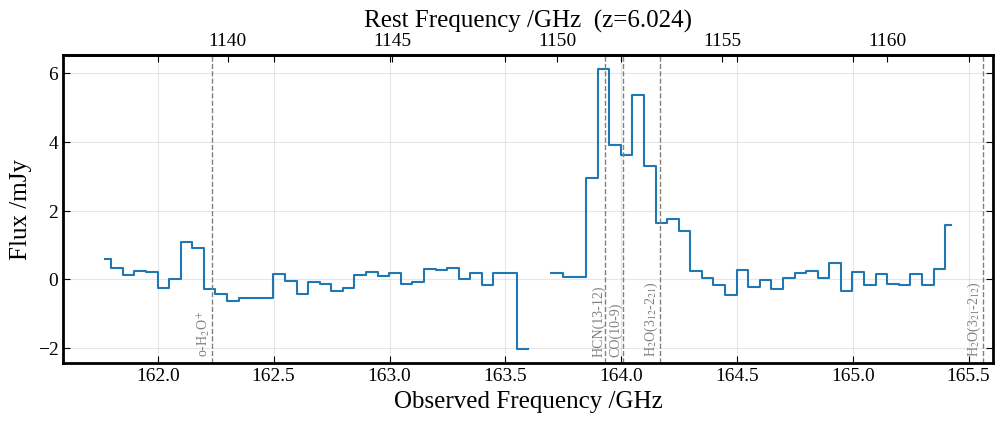

In [6]:
freq_obs, freq_rest, flux_jy, ax = plot_ap_spec_from_cube(
    os.path.join(dir_image, 'all_tbin60s.ms.contsub.T1.rob_2.0.sgm_2.0.dv_25MHz.image.pbcor.fits'),
    # os.path.join(dir_image, 'all_tbin60s.ms.T1.rob_2.0.sgm_2.0.image.pbcor.fits'),
    ra_deg=135.1907500000, dec_deg=0.6900500000,
    radius_arcsec=0.2,
    z=6.024,
    chanbin=2,
    edge_drop=(3,3), 
    lines_rest_mhz=LINES_REST_MHZ,
    line_obs_ghz_min=160,  # 160-170 GHz の輝線のみプロット
    line_obs_ghz_max=170,  
)
# cursor_artists = attach_cursor(ax, freq_obs, flux_jy, z=6.024)

plt.show()

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


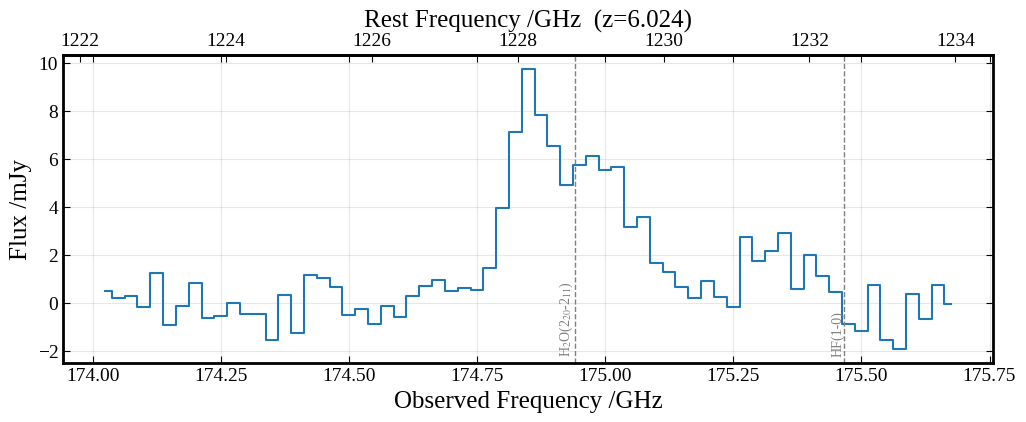

In [7]:
freq_obs, freq_rest, flux_jy, ax = plot_ap_spec_from_cube(
    os.path.join(dir_image, 'all_tbin60s.ms.contsub.T2.rob_2.0.sgm_2.0.dv_25MHz.image.pbcor.fits'),
    # os.path.join(dir_image, 'all_tbin60s.ms.T2.rob_2.0.sgm_2.0.image.pbcor.fits'),
    ra_deg=135.1907500000, dec_deg=0.6900500000,
    radius_arcsec=0.3,
    z=6.024,
    chanbin=0,
    edge_drop=(3,3), 
    lines_rest_mhz=LINES_REST_MHZ,
    line_obs_ghz_min=170,  # 170 GHz 以下の輝線のみプロット
    line_obs_ghz_max=180,  # 170 GHz 以下の輝線のみプロット
)
# cursor_artists = attach_cursor(ax, freq_obs, flux_jy, z=6.024)
plt.show()

# Define aperture

In [8]:
# ----- clean mask (デカすぎるとは思うが) -----
maskfits = os.path.join(dir_image, f"all_tbin{tbin}s.ms.cont.rob_{robust_mask}.sgm_{nsigma_mask}.mask.fits")
mask_clean = fits.getdata(maskfits)

# 今のマスクは天体があるところは1で、他の大半は0。しかし本体の外側に一つ邪魔な天体があるので。マスク画像の中心から半径50pixより外側は0にする
mask_clean[(np.arange(mask_clean.shape[0])[:, None] - mask_clean.shape[0]//2)**2 + (np.arange(mask_clean.shape[1]) - mask_clean.shape[1]//2)**2 > 50**2]=0

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Beam Continuum: 1.167 x 0.956 arcsec, PA=65.3 deg
Beam CO(10-9): 1.278 x 1.030 arcsec, PA=64.1 deg
Beam H$_2$O(2$_{20}$-2$_{11}$): 1.168 x 0.957 arcsec, PA=65.3 deg
Beam HF(1-0): 1.161 x 0.947 arcsec, PA=65.4 deg
Beam [OIII]88$\mu$m: 0.764 x 0.643 arcsec, PA=-66.2 deg
Beam [NII]205$\mu$m: 0.842 x 0.767 arcsec, PA=-60.5 deg


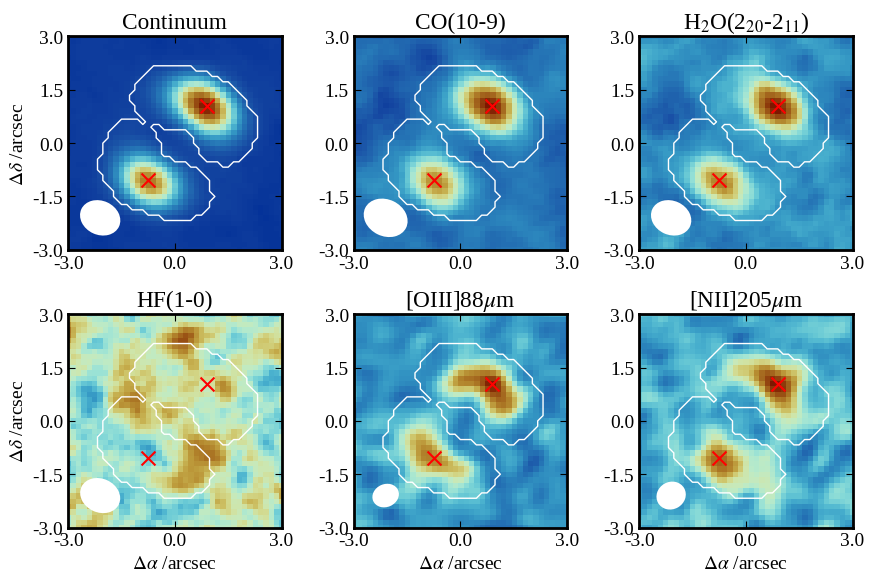

In [9]:
"""
ビームサイズ大きいのでピークピクセルだけでいい
"""

# --- Continuum map ---
fits_cont = os.path.join(dir_image, f"all_tbin{tbin}s.ms.cont.rob_{robust_mask}.sgm_{nsigma_mask}.image.fits")
# cont = conv_to_mjy_per_pix(fits_cont)
cont = fits.getdata(fits_cont)

# --- Robust, nsigma for line imaging ---
robust = 2.0
nsigma = 1.0
dv = 50  # km/s

# --- Continuum T2 map ---
fits_cont = os.path.join(dir_image, f"all_tbin{tbin}s.ms.cont.T2.rob_{robust}.sgm_{nsigma}.image.fits")
# cont = conv_to_mjy_per_pix(fits_cont)
cont = fits.getdata(fits_cont)


# --- Continuum n sigma level for mask ---
n = 50
_, _, rms_cont = sigma_clipped_stats(cont, sigma=5.0, maxiters=5)
mask_highSN = (cont > n*rms_cont).astype(bool)

# --- Peak pixel coordinates of each arc ---
# mask for arc 1
mask_arc = np.zeros_like(cont, dtype=bool)
mask_arc[200:220, 200:220] = True
cont_mask = np.where(mask_arc, cont, np.nan)
peak1 = np.unravel_index(np.nanargmax(cont_mask), cont.shape)
# mask for arc 2
mask_arc = np.zeros_like(cont, dtype=bool)
mask_arc[180:200, 180:200] = True
cont_mask = np.where(mask_arc, cont, np.nan)
peak2 = np.unravel_index(np.nanargmax(cont_mask), cont.shape)

# mask (2つのアークのピークピクセルのみ)
mask_peak = np.zeros_like(cont, dtype=bool)
mask_peak[peak1] = True
mask_peak[peak2] = True

# --- CO(10-9) moment-0 map ---
fits_CO109mom0 = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T1.rob_{robust}.sgm_{nsigma}.CO10-9.dv_{dv}.image.mom0.fits")
# CO109mom0 = conv_to_mjy_per_pix(fits_CO109mom0)
CO109mom0 = fits.getdata(fits_CO109mom0)

# --- H2O(2_20-2_11) moment-0 map ---
fits_H2Omom0 = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T2.rob_{robust}.sgm_{nsigma}.H2O220-211.dv_{dv}.image.mom0.fits")
# H2Omom0 = conv_to_mjy_per_pix(fits_H2Omom0)
H2Omom0 = fits.getdata(fits_H2Omom0)

# --- HF(1-0) moment-0 map ---
fits_HFmom0 = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T2.rob_{robust}.sgm_{nsigma}.HF1-0.dv_{dv}.image.mom0.fits")
# HFmom0 = conv_to_mjy_per_pix(fits_HFmom0)
HFmom0 = fits.getdata(fits_HFmom0)

# --- [OIII]88um moment-0 map ---
fits_OIII88mom0 = os.path.join(dir_image, f"OIII_rob_{robust}.sgm_{nsigma}.dv_{dv}.image.mom0.fits")
# OIII88mom0 = conv_to_mjy_per_pix(fits_OIII88mom0)
OIII88mom0 = fits.getdata(fits_OIII88mom0)
# reproject to match the shape of other maps
from reproject import reproject_exact
header_tar = fits.getheader(fits_OIII88mom0)
header_ref = fits.getheader(fits_cont)
wcs_tar = WCS(header_tar)
wcs_ref = WCS(header_ref)
shape_out = cont.shape
OIII88mom0_reproj, _ = reproject_exact((OIII88mom0, wcs_tar), wcs_ref, shape_out)
# scale flux to conserve total flux
# fac = (header_ref['CDELT2'] / header_tar['CDELT2']) ** 2
# OIII88mom0_reproj *= fac

# --- [NII]205um moment-0 map ---
fits_NII205mom0 = os.path.join(dir_image, f"NII_rob_{robust}.sgm_{nsigma}.dv_{dv}.image.mom0.fits")
# NII205mom0 = conv_to_mjy_per_pix(fits_NII205mom0)
NII205mom0 = fits.getdata(fits_NII205mom0)
# reproject to match the shape of other maps
header_tar = fits.getheader(fits_NII205mom0)
header_ref = fits.getheader(fits_cont)
wcs_tar = WCS(header_tar)
wcs_ref = WCS(header_ref)
shape_out = cont.shape
NII205mom0_reproj, _ = reproject_exact((NII205mom0, wcs_tar), wcs_ref, shape_out)
# fac = (header_ref['CDELT2'] / header_tar['CDELT2']) ** 2
# NII205mom0_reproj *= fac

# --- Plot maps ---
imlist = [cont, CO109mom0, H2Omom0, HFmom0, OIII88mom0_reproj, NII205mom0_reproj]
headerlist = [fits_cont, fits_CO109mom0, fits_H2Omom0, fits_HFmom0, fits_OIII88mom0, fits_NII205mom0]
titlelist = ['Continuum', 'CO(10-9)', r'H$_2$O(2$_{20}$-2$_{11}$)', 'HF(1-0)', r'[OIII]88$\mu$m', r'[NII]205$\mu$m']

fig, ax = plt.subplots(2, 3, figsize=(9, 6))
ax = ax.flatten()
for i, im in enumerate(imlist):
    ax[i].imshow(im, origin='lower', cmap=cm.roma_r)
    # clean mask
    ax[i].contour(mask_clean, levels=[0.5], colors='white', linewidths=1)
    # high SN mask
    # ax[i].contour(mask_highSN, levels=[0.5], colors='red', linewidths=1)

    # arcsec scaleで表示
    h = header_ref
    pix_size = h['CDELT2'] * 3600  # arcsec/pix
    def format_func(value, tick_number):
        return f"{(value - cont.shape[0]//2) * pix_size:.1f}"
    ax[i].xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax[i].set_xlim(180, 220)
    ax[i].set_ylim(180, 220)
    # ax[i].scatter(peal)

    # 軸ラベル
    if i % 3 == 0:
        ax[i].set_ylabel(r"$\Delta \delta$ /arcsec")

    if i // 3 == 1:
        ax[i].set_xlabel(r"$\Delta \alpha$ /arcsec")
    

    # 左下にbeamを描く（位置は図の相対的な位置で指定）
    h = fits.getheader(headerlist[i])
    bmaj, bmin, bpa = h['BMAJ']*3600, h['BMIN']*3600, h['BPA']  # arcsec
    print(f"Beam {titlelist[i]}: {bmaj:.3f} x {bmin:.3f} arcsec, PA={bpa:.1f} deg")
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    xx = xlim[0] + 0.15 * (xlim[1] - xlim[0])
    yy = ylim[0] + 0.15 * (ylim[1] - ylim[0])
    e = Ellipse(xy=(xx, yy), width=bmaj/pix_size, height=bmin/pix_size, angle=bpa+90, edgecolor='none', facecolor='white', lw=1.5)
    ax[i].add_patch(e)

    # title
    ax[i].set_title(titlelist[i])

    # peak pixels
    ax[i].scatter([peak1[1]], [peak1[0]], s=100, color='red', lw=1.5, marker='x')
    ax[i].scatter([peak2[1]], [peak2[0]], s=100, color='red', lw=1.5, marker='x')

fig.tight_layout()

Beam Continuum: 1.167 x 0.956 arcsec, PA=65.3 deg
Beam HF(1-0): 1.161 x 0.947 arcsec, PA=65.4 deg
Beam CO(10-9): 1.278 x 1.030 arcsec, PA=64.1 deg
Beam H$_2$O(2$_{20}$-2$_{11}$): 1.168 x 0.957 arcsec, PA=65.3 deg
Figure saved to ./fig/mom0_comparison.pdf


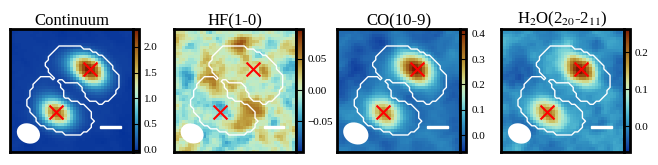

In [10]:
# 論文用に、continuum/CO(10-9)/H2O(2_20-2_11)/HF(1-0)のみプロット

# --- Plot maps ---
imlist = [cont*1e3, HFmom0, CO109mom0, H2Omom0]
headerlist = [fits_cont, fits_HFmom0, fits_CO109mom0, fits_H2Omom0]
titlelist = ['Continuum', 'HF(1-0)', 'CO(10-9)', r'H$_2$O(2$_{20}$-2$_{11}$)']

fig, ax = plt.subplots(1, 4, figsize=(8, 3))
fig.subplots_adjust(wspace=0.27)
ax = ax.flatten()
for i, im in enumerate(imlist):
    im = ax[i].imshow(im, origin='lower', cmap=cm.roma_r)
    # clean mask
    ax[i].contour(mask_clean, levels=[0.5], colors='white', linewidths=1)
    # high SN mask
    # ax[i].contour(mask_highSN, levels=[0.5], colors='red', linewidths=1)

    # カラーバー付き表示の準備
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.0)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    # cbar.ax.set_title(r"mJy beam$^{-1}$ km s$^{-1}$", fontsize=6, pad=3)

    # arcsec scaleで表示
    h = header_ref
    pix_size = h['CDELT2'] * 3600  # arcsec/pix
    ax[i].set_xlim(180, 220)
    ax[i].set_ylim(180, 220)
    # ax[i].scatter(peal)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # 軸ラベル
    # if i == 0:
    #     ax[i].set_ylabel(r"$\Delta \delta$ /arcsec")

    # ax[i].set_xlabel(r"$\Delta \alpha$ /arcsec")

    # --- Add 1 arcsec scale bar using AnchoredSizeBar ---
    import matplotlib.font_manager as fm
    fontprops = fm.FontProperties(size=8)
    scalebar = AnchoredSizeBar(
        ax[i].transData,
        size=1.0 / pix_size,  # 1 arcsec in pixels
        label='',
        loc='lower right',
        pad=1,
        color='white',
        frameon=False,
        size_vertical=0.6,
        fontproperties=fontprops
    )
    ax[i].add_artist(scalebar)
    

    # 左下にbeamを描く（位置は図の相対的な位置で指定）
    h = fits.getheader(headerlist[i])
    bmaj, bmin, bpa = h['BMAJ']*3600, h['BMIN']*3600, h['BPA']  # arcsec
    print(f"Beam {titlelist[i]}: {bmaj:.3f} x {bmin:.3f} arcsec, PA={bpa:.1f} deg")
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    xx = xlim[0] + 0.15 * (xlim[1] - xlim[0])
    yy = ylim[0] + 0.15 * (ylim[1] - ylim[0])
    e = Ellipse(xy=(xx, yy), width=bmaj/pix_size, height=bmin/pix_size, angle=bpa+90, edgecolor='none', facecolor='white', lw=1.5)
    ax[i].add_patch(e)

    # title
    ax[i].set_title(titlelist[i], fontsize=12, pad=-3)

    # peak pixels
    ax[i].scatter([peak1[1]], [peak1[0]], s=100, color='red', lw=1.5, marker='x')
    ax[i].scatter([peak2[1]], [peak2[0]], s=100, color='red', lw=1.5, marker='x')

# fig.tight_layout()

fig.savefig("./fig/mom0_comparison.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("Figure saved to ./fig/mom0_comparison.pdf")


Beam HF(1-0): 1.161 x 0.947 arcsec, PA=65.4 deg
Beam CO(10-9): 1.278 x 1.030 arcsec, PA=64.1 deg
Beam H$_2$O(2$_{20}$-2$_{11}$): 1.168 x 0.957 arcsec, PA=65.3 deg
Figure saved to ./fig/mom0_for_webrelease.pdf


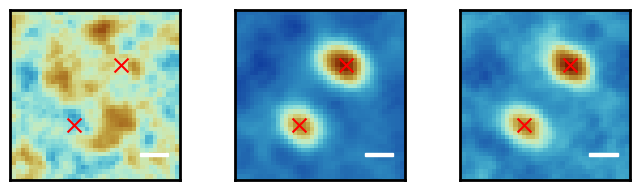

In [11]:
# Web release用に、CO(10-9)/H2O(2_20-2_11)/HF(1-0)のみプロット

# --- Plot maps ---
imlist = [HFmom0, CO109mom0, H2Omom0]
headerlist = [fits_HFmom0, fits_CO109mom0, fits_H2Omom0]
titlelist = ['HF(1-0)', 'CO(10-9)', r'H$_2$O(2$_{20}$-2$_{11}$)']

fig, ax = plt.subplots(1, 3, figsize=(8, 3))
fig.subplots_adjust(wspace=0.32)
ax = ax.flatten()
for i, im in enumerate(imlist):
    im = ax[i].imshow(im, origin='lower', cmap=cm.roma_r)
    # clean mask
    # ax[i].contour(mask_clean, levels=[0.5], colors='white', linewidths=1)
    # high SN mask
    # ax[i].contour(mask_highSN, levels=[0.5], colors='red', linewidths=1)

    # カラーバー付き表示の準備
    # divider = make_axes_locatable(ax[i])
    # cax = divider.append_axes("right", size="5%", pad=0.0)
    # cbar = fig.colorbar(im, cax=cax)
    # cbar.ax.tick_params(labelsize=8)
    # cbar.ax.set_title(r"mJy beam$^{-1}$ km s$^{-1}$", fontsize=6, pad=3)

    # arcsec scaleで表示
    h = header_ref
    pix_size = h['CDELT2'] * 3600  # arcsec/pix
    ax[i].set_xlim(180, 220)
    ax[i].set_ylim(180, 220)
    # ax[i].scatter(peal)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    # 軸ラベル
    # if i == 0:
    #     ax[i].set_ylabel(r"$\Delta \delta$ /arcsec")

    # ax[i].set_xlabel(r"$\Delta \alpha$ /arcsec")

    # --- Add 1 arcsec scale bar using AnchoredSizeBar ---
    import matplotlib.font_manager as fm
    fontprops = fm.FontProperties(size=8)
    scalebar = AnchoredSizeBar(
        ax[i].transData,
        size=1.0 / pix_size,  # 1 arcsec in pixels
        label='',
        loc='lower right',
        pad=1,
        color='white',
        frameon=False,
        size_vertical=0.6,
        fontproperties=fontprops
    )
    ax[i].add_artist(scalebar)
    

    # 左下にbeamを描く（位置は図の相対的な位置で指定）
    h = fits.getheader(headerlist[i])
    bmaj, bmin, bpa = h['BMAJ']*3600, h['BMIN']*3600, h['BPA']  # arcsec
    print(f"Beam {titlelist[i]}: {bmaj:.3f} x {bmin:.3f} arcsec, PA={bpa:.1f} deg")
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    xx = xlim[0] + 0.15 * (xlim[1] - xlim[0])
    yy = ylim[0] + 0.15 * (ylim[1] - ylim[0])
    e = Ellipse(xy=(xx, yy), width=bmaj/pix_size, height=bmin/pix_size, angle=bpa+90, edgecolor='none', facecolor='white', lw=1.5)
    # ax[i].add_patch(e)

    # title
    # ax[i].set_title(titlelist[i], fontsize=12, pad=-3)

    # peak pixels
    ax[i].scatter([peak1[1]], [peak1[0]], s=100, color='red', lw=1.5, marker='x')
    ax[i].scatter([peak2[1]], [peak2[0]], s=100, color='red', lw=1.5, marker='x')

# fig.tight_layout()

fig.savefig("./fig/mom0_for_webrelease.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("Figure saved to ./fig/mom0_for_webrelease.pdf")


## ピーク位置で測ったcontinuum subtraction前後のスペクトル

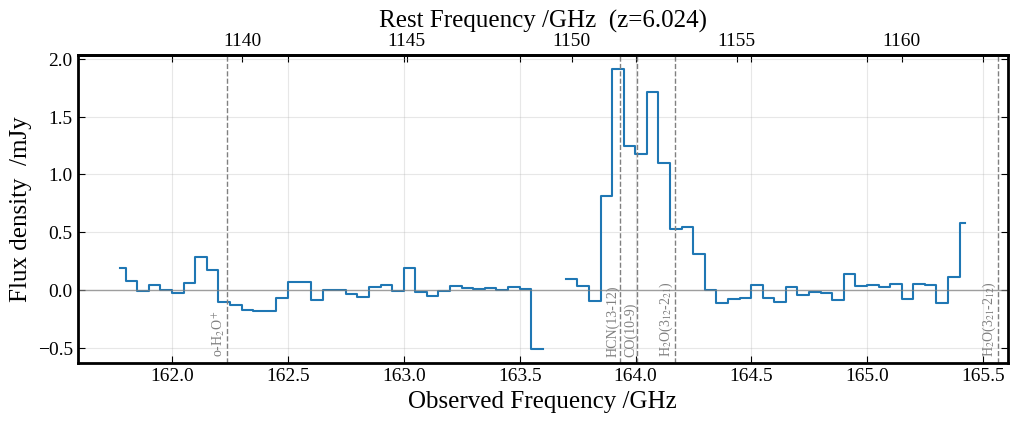

In [12]:
freq_obs, freq_rest, flux_jy, ax = plot_ap_spec_from_cube(
    # os.path.join(dir_image, 'all_tbin60s.ms.T1.rob_2.0.sgm_2.0.image.pbcor.fits'),
    os.path.join(dir_image, 'all_tbin60s.ms.contsub.T1.rob_2.0.sgm_2.0.dv_25MHz.image.pbcor.fits'),
    z=6.024,
    chanbin=2,
    edge_drop=(3,3), 
    lines_rest_mhz=LINES_REST_MHZ,
    line_obs_ghz_min=160,  # 160-170 GHz の輝線のみプロット
    line_obs_ghz_max=170,  
    mask2d=mask_peak
)
# cursor_artists = attach_cursor(ax, freq_obs, flux_jy, z=6.024)
ax.set_ylabel(r'Flux density  /mJy')
ax.axhline(0.0, color='gray', ls='-', lw=1, alpha=0.7)
plt.show()

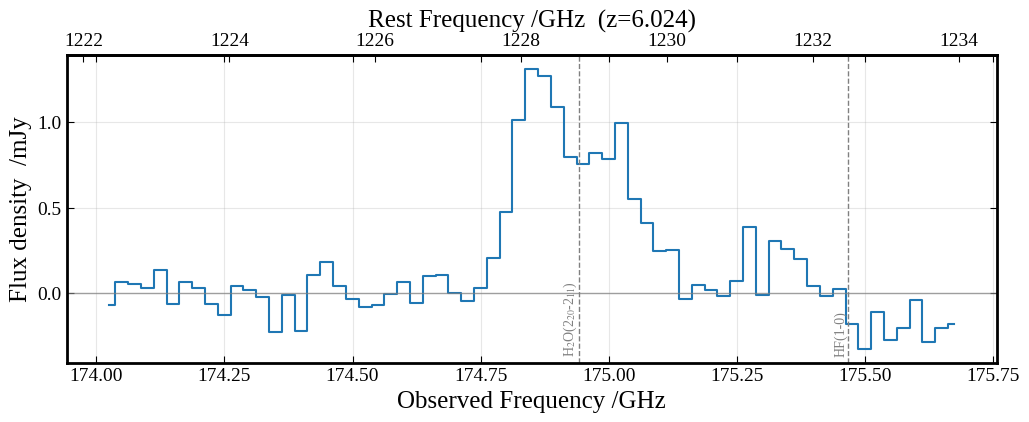

In [13]:
freq_obs, freq_rest, flux_jy, ax = plot_ap_spec_from_cube(
    # os.path.join(dir_image, 'all_tbin60s.ms.T2.rob_2.0.sgm_2.0.image.pbcor.fits'),
    os.path.join(dir_image, 'all_tbin60s.ms.contsub.T2.rob_2.0.sgm_2.0.dv_25MHz.image.pbcor.fits'),
    z=6.024,
    chanbin=0,
    edge_drop=(3,3), 
    lines_rest_mhz=LINES_REST_MHZ,
    line_obs_ghz_min=170,  # 170 GHz 以下の輝線のみプロット
    line_obs_ghz_max=180,  # 170 GHz 以下の輝線のみプロット
    mask2d=mask_peak
)
# cursor_artists = attach_cursor(ax, freq_obs, flux_jy, z=6.024)
ax.set_ylabel(r'Flux density  /mJy')
ax.axhline(0.0, color='gray', ls='-', lw=1, alpha=0.7)
plt.show()

# Overplot all lines

100%|██████████| 41/41 [00:00<00:00, 59.83it/s] 


Figure saved to ./fig/spectrum_comparison.pdf


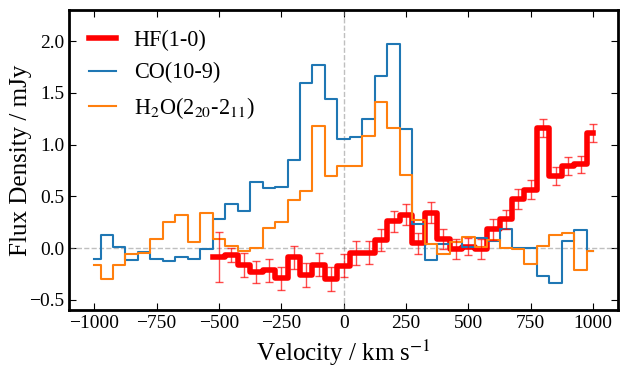

In [14]:
# choose mask
mask = mask_peak

# --- load data ---
robust = 2.0  # robust parameter for tclean
nsigma = 1.0  # noise threshold for tclean
width = "50km/s"


# CO(10-9)
fits_CO = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T1.rob_{robust}.sgm_{nsigma}.CO10-9.dv_{width.replace('km/s','')}.image.fits")
pbcorfits_CO = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T1.rob_{robust}.sgm_{nsigma}.CO10-9.dv_{width.replace('km/s','')}.image.pbcor.fits")
pb_CO = fits.getdata(fits_CO.replace('.image.fits', '.pb.fits'))
image_CO = conv_to_mjy_per_beam(fits_CO)

# H2O
fits_H2O = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T2.rob_{robust}.sgm_{nsigma}.H2O220-211.dv_{width.replace('km/s','')}.image.fits")
pbcorfits_H2O = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T2.rob_{robust}.sgm_{nsigma}.H2O220-211.dv_{width.replace('km/s','')}.image.pbcor.fits")
pb_H2O = fits.getdata(fits_H2O.replace('.image.fits', '.pb.fits'))
image_H2O = conv_to_mjy_per_beam(fits_H2O)

# HF
fits_HF = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T2.rob_{robust}.sgm_{nsigma}.HF1-0.dv_{width.replace('km/s','')}.image.fits")
pbcorfits_HF = os.path.join(dir_image, f"all_tbin{tbin}s.ms.contsub.T2.rob_{robust}.sgm_{nsigma}.HF1-0.dv_{width.replace('km/s','')}.image.pbcor.fits")
pb_HF = fits.getdata(fits_HF.replace('.image.fits', '.pb.fits'))
image_HF = conv_to_mjy_per_beam(fits_HF)


# --- extract spectrum ---
velocity = -1000 + np.arange(image_CO.shape[0]) * 50  # km/s

spectrum = {}
spectrum_err = {}

# CO
spec = np.empty(image_CO.shape[0], dtype=float)
spec_err = np.empty(image_CO.shape[0], dtype=float)
for k in tqdm(range(image_CO.shape[0])):
    spec[k] = np.nansum(image_CO[k] * mask)
    # spec_err[k] = estimate_rms_random_aperture(image_CO[k], mask, n_mc=100)
spectrum['CO(10-9)'] = spec
# spectrum_err['CO(10-9)'] = spec_err

# H2O
spec = np.empty(image_H2O.shape[0], dtype=float)
spec_err = np.empty(image_H2O.shape[0], dtype=float)
for k in tqdm(range(image_H2O.shape[0])):
    spec[k] = np.nansum(image_H2O[k] * mask)
    spec_err[k] = estimate_rms_random_aperture(image_H2O[k], mask, n_mc=1000)
spectrum['H2O(220-211)'] = spec
spectrum_err['H2O(220-211)'] = spec_err


# HF
spec = np.empty(image_HF.shape[0], dtype=float)
spec_err = np.empty(image_HF.shape[0], dtype=float)
for k in tqdm(range(image_HF.shape[0])):
    spec[k] = np.nansum(image_HF[k] * mask)
    if spec[k] == 0:
        spec[k] = np.nan
        continue
    spec_err[k] = estimate_rms_random_aperture(image_HF[k], mask, n_mc=1000) 
    
spectrum['HF(1-0)'] = spec
spectrum_err['HF(1-0)'] = spec_err

# --- plot spectrum ---
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.set_xlabel(r"Velocity / km s$^{-1}$", fontsize=18)
ax.set_ylabel(r"Flux Density / mJy", fontsize=18, labelpad=-2)
ax.axhline(0, color='gray', ls='--', lw=1, alpha=0.5)
ax.axvline(0, color='gray', ls='--', lw=1, alpha=0.5)

ax.step(velocity, spectrum["HF(1-0)"], where='mid', label="HF(1-0)", color='red', lw=4)
ax.step(velocity, spectrum["CO(10-9)"], where='mid', label="CO(10-9)")
ax.step(velocity, spectrum["H2O(220-211)"], where='mid', label=r"H$_2$O(2$_{20}$-2$_{11}$)")
ax.errorbar(
    velocity,
    spectrum["HF(1-0)"],
    yerr=spectrum_err["HF(1-0)"],              # HF のエラー配列
    fmt="none",                 # 点は打たない
    ecolor='red',
    elinewidth=1,
    capsize=3,
    alpha=0.7
)

ax.set_ylim(-0.6, 2.3)
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig("./fig/spectrum_comparison.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("Figure saved to ./fig/spectrum_comparison.pdf")

In [15]:
# H2O輝線について、各チャンネルのSNを求める
snr_H2O = spectrum['H2O(220-211)'] / spectrum_err['H2O(220-211)']
for k in range(len(velocity)):
    print(f"Velocity: {velocity[k]:.1f} km/s, S/N: {snr_H2O[k]:.2f}")


# SN>1のチャンネルを選ぶ
sn_threshold = 1.0
H2O_signal_channels = np.where((snr_H2O > sn_threshold) & (np.abs(velocity) < 500))[0]
print(f"H2O S/N > {sn_threshold} channels: {H2O_signal_channels} (velocities: {velocity[H2O_signal_channels]})")

Velocity: -1000.0 km/s, S/N: -1.50
Velocity: -950.0 km/s, S/N: -2.62
Velocity: -900.0 km/s, S/N: -1.47
Velocity: -850.0 km/s, S/N: -0.51
Velocity: -800.0 km/s, S/N: -0.39
Velocity: -750.0 km/s, S/N: 0.80
Velocity: -700.0 km/s, S/N: 2.41
Velocity: -650.0 km/s, S/N: 3.17
Velocity: -600.0 km/s, S/N: 0.56
Velocity: -550.0 km/s, S/N: 3.42
Velocity: -500.0 km/s, S/N: 0.91
Velocity: -450.0 km/s, S/N: 0.18
Velocity: -400.0 km/s, S/N: -0.41
Velocity: -350.0 km/s, S/N: -0.04
Velocity: -300.0 km/s, S/N: 1.94
Velocity: -250.0 km/s, S/N: 2.74
Velocity: -200.0 km/s, S/N: 4.95
Velocity: -150.0 km/s, S/N: 6.10
Velocity: -100.0 km/s, S/N: 13.36
Velocity: -50.0 km/s, S/N: 7.68
Velocity: 0.0 km/s, S/N: 8.47
Velocity: 50.0 km/s, S/N: 9.13
Velocity: 100.0 km/s, S/N: 12.77
Velocity: 150.0 km/s, S/N: 16.57
Velocity: 200.0 km/s, S/N: 13.29
Velocity: 250.0 km/s, S/N: 8.06
Velocity: 300.0 km/s, S/N: 3.47
Velocity: 350.0 km/s, S/N: 0.44
Velocity: 400.0 km/s, S/N: -0.73
Velocity: 450.0 km/s, S/N: 0.81
Velocity: 5

In [16]:
# HF吸収線について、各チャンネルのSNを求める
snr_HF = -spectrum['HF(1-0)'] / spectrum_err['HF(1-0)']
for k in range(len(velocity)):
    print(f"Velocity: {velocity[k]:.1f} km/s, S/N: {snr_HF[k]:.2f}")


# SN>1のチャンネルを選ぶ
sn_threshold = 1.0
HF_signal_channels = np.where((snr_HF > sn_threshold) & (np.abs(velocity) < 500))[0]
print(f"HF S/N > {sn_threshold} channels: {HF_signal_channels} (velocities: {velocity[HF_signal_channels]})")

Velocity: -1000.0 km/s, S/N: nan
Velocity: -950.0 km/s, S/N: nan
Velocity: -900.0 km/s, S/N: nan
Velocity: -850.0 km/s, S/N: nan
Velocity: -800.0 km/s, S/N: nan
Velocity: -750.0 km/s, S/N: nan
Velocity: -700.0 km/s, S/N: nan
Velocity: -650.0 km/s, S/N: nan
Velocity: -600.0 km/s, S/N: nan
Velocity: -550.0 km/s, S/N: nan
Velocity: -500.0 km/s, S/N: 0.36
Velocity: -450.0 km/s, S/N: 1.02
Velocity: -400.0 km/s, S/N: 1.37
Velocity: -350.0 km/s, S/N: 2.12
Velocity: -300.0 km/s, S/N: 1.94
Velocity: -250.0 km/s, S/N: 2.60
Velocity: -200.0 km/s, S/N: 0.80
Velocity: -150.0 km/s, S/N: 2.26
Velocity: -100.0 km/s, S/N: 1.48
Velocity: -50.0 km/s, S/N: 2.56
Velocity: 0.0 km/s, S/N: 1.51
Velocity: 50.0 km/s, S/N: 0.42
Velocity: 100.0 km/s, S/N: 0.39
Velocity: 150.0 km/s, S/N: -0.71
Velocity: 200.0 km/s, S/N: -2.53
Velocity: 250.0 km/s, S/N: -3.08
Velocity: 300.0 km/s, S/N: -0.47
Velocity: 350.0 km/s, S/N: -3.40
Velocity: 400.0 km/s, S/N: -0.86
Velocity: 450.0 km/s, S/N: 0.11
Velocity: 500.0 km/s, S/N: 

In [17]:
np.nanmin(spectrum["HF(1-0)"]), np.nanargmin(spectrum["HF(1-0)"]), velocity[np.nanargmin(spectrum["HF(1-0)"])]

(np.float64(-0.3002350330352783), np.int64(19), np.int64(-50))

In [18]:
# 論文に書くデータ用に、データのRMSを求めておく (mJy/beam)
e = []
for i in range(image_HF.shape[0]):
    _, _, e_i = sigma_clipped_stats(image_HF[i], sigma=3.0, maxiters=5)
    e.append(e_i)
e = np.array(e)


# エラーを計算する際に含める速度範囲
vel_lo = -300
vel_hi =  300
# vel_lo = -450
# vel_hi =  0

e_HF = e[np.logical_and(velocity >= vel_lo, velocity <= vel_hi)]
err_HF_med = np.nanmedian(e_HF)
print(f"Error of HF(1-0) spectrum within {vel_lo} to {vel_hi} km/s: {err_HF_med:.3f} mJy/beam")

/home/tsujtaak/miniconda3/envs/alpine/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:61: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/home/tsujtaak/miniconda3/envs/alpine/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:61: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/home/tsujtaak/miniconda3/envs/alpine/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:61: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/home/tsujtaak/miniconda3/envs/alpine/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:61: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/home/tsujtaak/miniconda3/envs/alpine/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:61: RuntimeWarning: Mean of empty slice
  return bottleneck.nanmean(array, axis=axis)
/home/tsujtaak/miniconda3/envs/alpine/lib/python3.11/site-packages/astropy/

Error of HF(1-0) spectrum within -300 to 300 km/s: 0.079 mJy/beam


In [19]:
# peak SN
np.nanmin(spectrum["HF(1-0)"]) / err_HF_med

np.float64(-3.7905661176032353)

## Upper limitの計算

Continuum T2 total flux: 4.2385 +/- 0.0163 mJy (S/N=260.8)


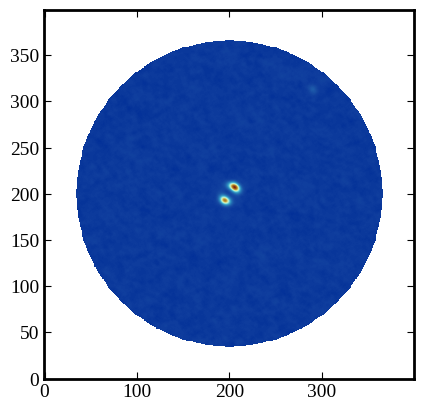

In [20]:
# Underlying continuum level
fits_cont_T2 = os.path.join(dir_image, f"all_tbin{tbin}s.ms.cont.T2.rob_{robust}.sgm_{nsigma}.image.fits")
# cont_T2 = conv_to_mjy_per_pix(fits_cont_T2)
cont_T2 = fits.getdata(fits_cont_T2) * 1e3 # mJy/beam

# total flux 
flux_cont_T2 = np.nansum(cont_T2 * mask)
# error from random aperture
err_cont_T2 = estimate_rms_random_aperture(cont_T2, mask, n_mc=1000)
print(f"Continuum T2 total flux: {flux_cont_T2:.4f} +/- {err_cont_T2:.4f} mJy (S/N={flux_cont_T2/err_cont_T2:.1f})")


plt.imshow(cont_T2, origin='lower', cmap=cm.roma_r)

In [21]:
# エラーを計算する際に含める速度範囲
# vel_lo = -200
# vel_hi =  200
vel_lo = -300
vel_hi =  300
# vel_lo = -450
# vel_hi =  0

flux_HF = spectrum['HF(1-0)'][np.logical_and(velocity >= vel_lo, velocity <= vel_hi)]
flux_HF_int = np.nansum(flux_HF) * 50  # km/s  #
err_HF = spec_err[np.logical_and(velocity >= vel_lo, velocity <= vel_hi)]
err_HF_med = np.nanmedian(err_HF)
err_HF_int = np.sqrt(np.sum(err_HF**2)) * 50  # km/s  # 50はチャネル幅
print(f"HF(1-0) integrated flux (over {vel_lo} to {vel_hi} km/s): {flux_HF_int:.3f} ± {err_HF_int:.3f} mJy km/s (S/N={flux_HF_int/err_HF_int:.1f})")

HF(1-0) integrated flux (over -300 to 300 km/s): -43.353 ± 19.825 mJy km/s (S/N=-2.2)


In [22]:
np.median(err_HF)

np.float64(0.11086223123343401)

In [23]:
# upper limit
SNR = 5
HF_flux_ul = SNR * err_HF

# # アインシュタイン係数
# A10 = 2.42e-2 / u.s # s^-1
# # 周波数
# nu = LINES_REST_MHZ["HF(1-0)"] * u.MHz

# tau_i = HF_flux_ul / flux_cont_T2
tau_i = -np.log(1 - HF_flux_ul / flux_cont_T2)
tau = np.sqrt(np.sum(tau_i**2))
print(f"HF(1-0) optical depth upper limit (S/N={SNR}): tau < {tau:.3f}")

NHF = tau * 500 / (4.16e-13)
NHF / 1e14

HF(1-0) optical depth upper limit (S/N=5): tau < 0.501


np.float64(6.022654328609179)

In [24]:
# detectionだとすると、、
# print("If detection:")

# tau_i = flux_HF_int / flux_cont_T2
# tau = np.sqrt(np.sum(tau_i**2))
# print(f"HF(1-0) optical depth upper limit (S/N={SNR}): tau < {tau:.3f}")

# NHF = tau * 500 / (4.16e-13)
# NHF / 1e14

In [25]:
np.median(tau_i)

np.float64(0.14015977909569063)

In [26]:
# # N_H2を計算する
# mu_Lp_CO21 = 2.0e11 * u.K * u.km / u.s * u.pc**2 # taken into account the CMB effect
# alpha_CO = 1.0 * u.Msun / (u.K * u.km / u.s * u.pc**2)  # Msun/(K km/s pc^2)
# r_21 = 0.83  # CO(2-1)/CO(1-0) luminosity ratio

# mu_Lp_CO10 = mu_Lp_CO21 / r_21




from astropy.constants import m_p
Re = 1 * u.kpc  # half-light radius
M_H2 = 2.0e10 * u.Msun  # (2.0 ± 0.7) * 1e10 Msun (Zavala+2022)
source_area = np.pi * Re**2
NH2 = (M_H2 / 2 / source_area / (m_p * 2 / 1.36)).to(u.cm**-2)
NH = NH2 / 2
# print(f"N_H2 = {NH2:.3e}, N_H = {NH:.3e} cm^-2")
NH2

<Quantity 2.70250232e+23 1 / cm2>

In [27]:
NHF / NH2.value

np.float64(2.228547332070172e-09)

In [28]:
HF_ratio = np.log10(NHF / NH2.value)
HF_ratio

np.float64(-8.651978137508433)

## Compare with Kobayashi-san's model

In [29]:
# read .dat files
data0 = np.loadtxt('./data/chemical_model/new/fluorine_model0.dat', skiprows=1)
data1 = np.loadtxt('./data/chemical_model/new/fluorine_model1.dat', skiprows=1)
data2 = np.loadtxt('./data/chemical_model/new/fluorine_model2.dat', skiprows=1)
data3 = np.loadtxt('./data/chemical_model/new/fluorine_model3.dat', skiprows=1)
data4 = np.loadtxt('./data/chemical_model/new/fluorine_model4.dat', skiprows=1)
data5 = np.loadtxt('./data/chemical_model/new/fluorine_model5.dat', skiprows=1)
data6 = np.loadtxt('./data/chemical_model/new/fluorine_model6.dat', skiprows=1)
data7 = np.loadtxt('./data/chemical_model/new/fluorine_model7.dat', skiprows=1)
data8 = np.loadtxt('./data/chemical_model/new/fluorine_model8.dat', skiprows=1)
data9 = np.loadtxt('./data/chemical_model/new/fluorine_model9.dat', skiprows=1)
# data10 = np.loadtxt('./data/chemical_model/new/fluorine_model10.dat', skiprows=1)
data10 = np.loadtxt('./data/chemical_model/new/fluorine_model_x170new.dat', skiprows=1)

$A(X) = \log_{10} \left(\frac{N_X}{N_H}\right)+12$ 

$[X/H] = A(X) - A(X)_\odot = \log_{10} \left(\frac{N_X}{N_H}\right) - \log_{10} \left(\frac{N_X}{N_H}\right)_\odot$

$12 + \log_{10}(O/H) = [12 + \log_{10}(O/H)]_\odot + \log_{10}(Z/Z_\odot)$

In [30]:
# # from astropy.cosmology import Planck18 as cosmo
# from astropy.cosmology import FlatLambdaCDM 

# cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# z_form = 7.68
# t_form = cosmo.age(z=z_form)
# age_universe = cosmo.age(0.0001)

# # 安全な z_at_value ラッパ
# def safe_z(t_array):
#     t_total = t_form + t_array * u.Gyr
#     # 宇宙年齢を超えるところはクリップ（= z=0 方向に自然に落ちる）
#     t_total = np.minimum(t_total, age_universe)

#     return np.array([z_at_value(cosmo.age, tt) for tt in t_total])


# # ---- ここから先の構造は変えない ----
# t0, AO0, AF0 = data0[:,0], data0[:,1], data0[:,2]
# z0 = safe_z(t0) # model0 は時間軸がずれているっぽいので手動で補正

# t1, AO1, AF1 = data1[:,0], data1[:,1], data1[:,2]
# z1 = safe_z(t1)

# t2, AO2, AF2 = data2[:,0], data2[:,1], data2[:,2]
# z2 = safe_z(t2)

# t3, AO3, AF3 = data3[:,0], data3[:,1], data3[:,2]
# z3 = safe_z(t3)

# t4, AO4, AF4 = data4[:,0], data4[:,1], data4[:,2]
# z4 = safe_z(t4)

# t5, AO5, AF5 = data5[:,0], data5[:,1], data5[:,2]
# z5 = safe_z(t5)

# t6, AO6, AF6 = data6[:,0], data6[:,1], data6[:,2]
# z6 = safe_z(t6)

# t7, AO7, AF7 = data7[:,0], data7[:,1], data7[:,2]
# z7 = safe_z(t7)

# t8, AO8, AF8 = data8[:,0], data8[:,1], data8[:,2]
# z8 = safe_z(t8)

In [31]:
# for new model

t0, AO0, AF0, fg0, z0 = data0[:,0], data0[:,1], data0[:,2], data0[:,3], data0[:,4]
t1, AO1, AF1, fg1, z1 = data1[:,0], data1[:,1], data1[:,2], data1[:,3], data1[:,4]
t2, AO2, AF2, fg2, z2 = data2[:,0], data2[:,1], data2[:,2], data2[:,3], data2[:,4]
t3, AO3, AF3, fg3, z3 = data3[:,0], data3[:,1], data3[:,2], data3[:,3], data3[:,4]
t4, AO4, AF4, fg4, z4 = data4[:,0], data4[:,1], data4[:,2], data4[:,3], data4[:,4]
t5, AO5, AF5, fg5, z5 = data5[:,0], data5[:,1], data5[:,2], data5[:,3], data5[:,4]
t6, AO6, AF6, fg6, z6 = data6[:,0], data6[:,1], data6[:,2], data6[:,3], data6[:,4]
t7, AO7, AF7, fg7, z7 = data7[:,0], data7[:,1], data7[:,2], data7[:,3], data7[:,4]
t8, AO8, AF8, fg8, z8 = data8[:,0], data8[:,1], data8[:,2], data8[:,3], data8[:,4]
t9, AO9, AF9, fg9, z9 = data9[:,0], data9[:,1], data9[:,2], data9[:,3], data9[:,4]
t10, AO10, AF10, fg10, z10 = data10[:,0], data10[:,1], data10[:,2], data10[:,3], data10[:,4]

saved ./fig/chemical_evolution_models_comparison1.pdf


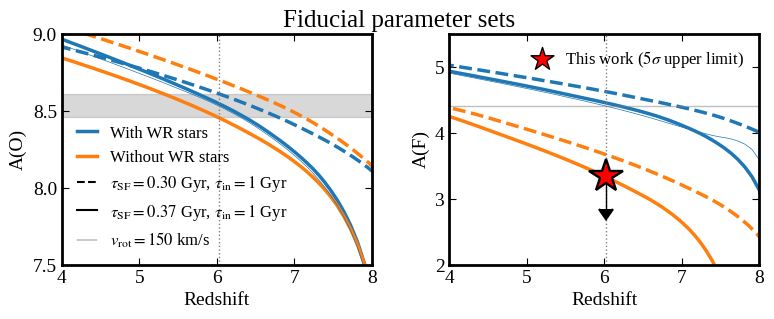

In [32]:
Zsun = 8.76 # Asplund et al. (2009), Kobayashi+20

# Tadaki et al. (2022) Z=0.5-0.7 Z_sun 
Z_g09_low = Zsun + np.log10(0.5)
Z_g09_upp = Zsun + np.log10(0.7)

lw = 2.5

fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.subplots_adjust(wspace=0.25)
ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('A(O)')
ax[0].plot(z0, AO0, color='tab:blue', ls='--', lw=lw)
ax[0].plot(z3, AO3, color='tab:blue', ls='-', label="With WR stars", lw=lw)
ax[0].plot(z2, AO2, color='tab:orange', ls='--', lw=lw)
ax[0].plot(z1, AO1, color='tab:orange', ls='-', label="Without WR stars", lw=lw)
# 150 km/s model
# ax[0].plot(z8, AO8, color='tab:blue', ls='dashdot')
ax[0].plot(z8, AO8, color='tab:blue', ls='-', lw=0.5)

ax[0].plot([], [], color='black', ls='--', label=r'$\tau_{\rm SF}=0.30$ Gyr, $\tau_{\rm in}=1$ Gyr')
ax[0].plot([], [], color='black', ls='-', label=r'$\tau_{\rm SF}=0.37$ Gyr, $\tau_{\rm in}=1$ Gyr')
# ax[0].plot([], [], color='black', ls='dashdot', label="150 km/s")
ax[0].plot([], [], color='black', ls='-', lw=0.3, label=r"$v_{\rm rot}=150$ km/s")
ax[0].axvline(6.024, color='gray', ls=':', lw=1)

# G09の金属量範囲を帯で表示
ax[0].axhspan(Z_g09_low, Z_g09_upp, color='gray', alpha=0.3)
ax[0].legend()


ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('A(F)')
ax[1].plot(z0, AF0, color='tab:orange', ls='--', lw=lw)
ax[1].plot(z1, AF1, color='tab:orange', ls='-', lw=lw)
ax[1].plot(z2, AF2, color='tab:blue', ls='--', lw=lw)
ax[1].plot(z3, AF3, color='tab:blue', ls='-', lw=lw)
# 150 km/s model
# ax[1].plot(z8, AF8, color='tab:blue', ls='dashdot')
ax[1].plot(z8, AF8, color='tab:blue', ls='-', lw=0.5)

# 観測結果 (上限値なので下向きに矢印、赤い丸を黒い縁取りで囲む)
ax[1].errorbar(
    x=6.024, y=12+HF_ratio, color='red',
    yerr=0.5, fmt='*', ecolor='black', elinewidth=1., capsize=5, markersize=25, mec='black', mew=1.7,
    barsabove=False, lolims=False, uplims=True, xlolims=False, xuplims=False, errorevery=1, capthick=None, zorder=4,
    )

# legend用 のダミー点
ax[1].scatter(
    x=[], y=[], color='red',
    marker='*', s=300, edgecolor='black', linewidth=1,
    label=r'This work ($5\sigma$ upper limit)'
    )


# ax[1].plot([], [], color='black', ls='-', label=r"Rotation 150 km$\,$s$^{-1}$")

ax[1].axvline(6.024, color='gray', ls=':', lw=1)

ax[0].set_xlim(4,8)
ax[0].set_ylim(7.5, 9)
ax[1].set_xlim(4,8)
ax[1].set_ylim(2, 5.5)
ax[1].legend(loc='upper right')

# solar abundance
ax[1].axhline(4.4, color="gray", ls="-", alpha=0.5, lw=1) # Asplund et al. (2009) --> Maiorca et al. (2014) に合わせて4.56 --> 4.4に修正

fig.suptitle("Fiducial parameter sets", fontsize=18, y=0.96)

fig.savefig("./fig/chemical_evolution_models_comparison1.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("saved ./fig/chemical_evolution_models_comparison1.pdf")

/tmp/ipykernel_411323/2910627297.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(loc='upper right')


saved ./fig/for_webrelease.pdf


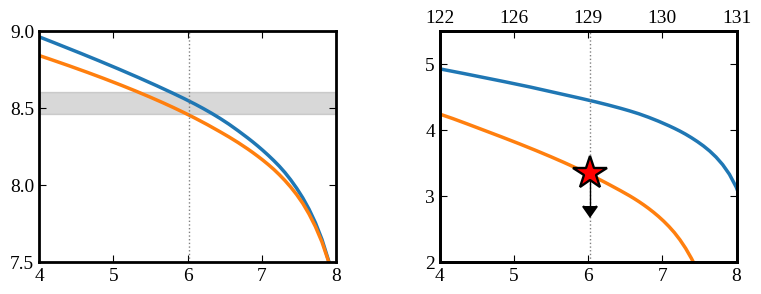

In [53]:
# For web release

fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.subplots_adjust(wspace=0.35)
# ax[0].set_xlabel('Redshift')
# ax[0].set_ylabel(r'$12 + \log(\mathrm{O/H})$')
# ax[0].plot(z0, AO0, color='tab:blue', ls='--', lw=lw)
ax[0].plot(z3, AO3, color='tab:blue', ls='-', label="With WR stars", lw=lw)
# ax[0].plot(z2, AO2, color='tab:orange', ls='--', lw=lw)
ax[0].plot(z1, AO1, color='tab:orange', ls='-', label="Without WR stars", lw=lw)
# 150 km/s model
# ax[0].plot(z8, AO8, color='tab:blue', ls='dashdot')
# ax[0].plot(z8, AO8, color='tab:blue', ls='-', lw=0.5)

# ax[0].plot([], [], color='black', ls='--', label=r'$\tau_{\rm SF}=0.30$ Gyr, $\tau_{\rm in}=1$ Gyr')
ax[0].plot([], [], color='black', ls='-', label=r'$\tau_{\rm SF}=0.37$ Gyr, $\tau_{\rm in}=1$ Gyr')
# ax[0].plot([], [], color='black', ls='dashdot', label="150 km/s")
# ax[0].plot([], [], color='black', ls='-', lw=0.3, label=r"$v_{\rm rot}=150$ km/s")
ax[0].axvline(6.024, color='gray', ls=':', lw=1)

# G09の金属量範囲を帯で表示
ax[0].axhspan(Z_g09_low, Z_g09_upp, color='gray', alpha=0.3)
# ax[0].legend()


# ax[1].set_xlabel('Redshift')
# ax[1].set_ylabel(r'$12 + \log(\mathrm{F/H})$')
# ax[1].plot(z0, AF0, color='tab:orange', ls='--', lw=lw)
ax[1].plot(z1, AF1, color='tab:orange', ls='-', lw=lw)
# ax[1].plot(z2, AF2, color='tab:blue', ls='--', lw=lw)
ax[1].plot(z3, AF3, color='tab:blue', ls='-', lw=lw)
# 150 km/s model
# ax[1].plot(z8, AF8, color='tab:blue', ls='dashdot')
# ax[1].plot(z8, AF8, color='tab:blue', ls='-', lw=0.5)

# 観測結果 (上限値なので下向きに矢印、赤い丸を黒い縁取りで囲む)
ax[1].errorbar(
    x=6.024, y=12+HF_ratio, color='red',
    yerr=0.5, fmt='*', ecolor='black', elinewidth=1., capsize=5, markersize=25, mec='black', mew=1.7,
    barsabove=False, lolims=False, uplims=True, xlolims=False, xuplims=False, errorevery=1, capthick=None, zorder=4,
    )

# legend用 のダミー点
# ax[1].scatter(
#     x=[], y=[], color='red',
#     marker='*', s=300, edgecolor='black', linewidth=1,
#     label=r'This work ($5\sigma$ upper limit)'
#     )


# ax[1].plot([], [], color='black', ls='-', label=r"Rotation 150 km$\,$s$^{-1}$")

ax[1].axvline(6.024, color='gray', ls=':', lw=1)

ax[0].set_xlim(4,8)
ax[0].set_ylim(7.5, 9)
ax[1].set_xlim(4,8)
ax[1].set_ylim(2, 5.5)
ax[1].legend(loc='upper right')

# solar abundance
# ax[1].axhline(4.4, color="gray", ls="-", alpha=0.5, lw=1) # Asplund et al. (2009) --> Maiorca et al. (2014) に合わせて4.56 --> 4.4に修正

# fig.suptitle("Fiducial parameter sets", fontsize=18, y=0.96)

# 上のx軸に、各赤方偏移が何億年前に対応するか(lookback time)を追加
from astropy.cosmology import Planck18 as cosmo
z_ticks = [4, 5, 6, 7, 8]
t_ticks = cosmo.lookback_time(z_ticks) * 10
t_tick_labels = [f"{t.value:.0f}" for t in t_ticks]

ax_top = ax[1].twiny()
ax_top.set_xlim(ax[1].get_xlim())          # 下側と範囲を一致
ax_top.set_xticks(z_ticks)                 # ★ これが重要：位置をzに合わせる
ax_top.set_xticklabels(t_tick_labels)
# ax_top.set_xlabel("Lookback time [Gyr]")   # 任意

fig.savefig("./fig/for_webrelease.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("saved ./fig/for_webrelease.pdf")

In [34]:
# alpha = 0.25

# fig, ax = plt.subplots(1, 2, figsize=(8,3))
# fig.subplots_adjust(wspace=0.25)
# ax[0].set_xlabel('Redshift')
# ax[0].set_ylabel('A(O)')

# # Fiducial models
# ax[0].plot(z0, AO0, color='tab:green', ls='--', alpha=alpha)
# ax[0].plot(z3, AO3, color='tab:green', ls='-', alpha=alpha)
# ax[0].plot(z2, AO2, color='tab:orange', ls='--', alpha=alpha)
# ax[0].plot(z1, AO1, color='tab:orange', ls='-', alpha=alpha)

# # 150 km/s model
# ax[0].plot(z4, AO4, color='black', ls='-', label="150 km/s")
# # IMF (x=1.1) model
# ax[0].plot(z5, AO5, color='red', ls='dotted', label=r"$x=1.1, \tau=0.3\,\mathrm{Gyr}$")
# # IMF (x=1.7) model
# ax[0].plot(z6, AO6, color='blue', ls='dotted', label=r"$x=1.7, \tau=0.3\,\mathrm{Gyr}$")
# # IMF (x=1.1, tau=0.5) model
# ax[0].plot(z7, AO7, color='red', ls='-', label=r"$x=1.1, \tau=0.5\,\mathrm{Gyr}$")
# # IMF (x=1.7, tau=0.1) model
# ax[0].plot(z8, AO8, color='blue', ls='-', label=r"$x=1.7, \tau=0.1\,\mathrm{Gyr}$")

# ax[0].axvline(6.024, color='gray', ls=':', lw=1)

# # G09の金属量範囲を帯で表示
# ax[0].axhspan(Z_g09_low, Z_g09_upp, color='gray', alpha=0.3)
# ax[0].legend()


# ax[1].set_xlabel('Redshift')
# ax[1].set_ylabel('A(F)')

# # Fiducial models
# ax[1].plot(z0, AF0, color='tab:orange', ls='--', alpha=alpha)
# ax[1].plot(z1, AF1, color='tab:orange', ls='-', alpha=alpha)
# ax[1].plot(z2, AF2, color='tab:green', ls='--', alpha=alpha)
# ax[1].plot(z3, AF3, color='tab:green', ls='-', alpha=alpha)

# # 150 km/s model
# ax[1].plot(z4, AF4, color='black', ls='-')
# # IMF (x=1.1) model
# ax[1].plot(z5, AF5, color='red', ls='dotted', label=r"$x=1.1\,\mathrm{Gyr}$")
# # IMF (x=1.7) model
# ax[1].plot(z6, AF6, color='blue', ls='dotted', label=r"$x=1.7\,\mathrm{Gyr}$")
# # IMF (x=1.1, tau=0.5) model
# ax[1].plot(z7, AF7, color='red', ls='-', label=r"$x=1.1, \tau=0.5\,\mathrm{Gyr}$")
# # IMF (x=1.7, tau=0.1) model
# ax[1].plot(z8, AF8, color='blue', ls='-', label=r"$x=1.7, \tau=0.1\,\mathrm{Gyr}$")

# # 観測結果 (上限値なので下向きに矢印、赤い丸を黒い縁取りで囲む)
# ax[1].errorbar(
#     x=6.024, y=12+HF_ratio, color='red',
#     yerr=0.5, fmt='*', ecolor='black', elinewidth=1., capsize=5, markersize=25, mec='black', mew=1.7,
#     barsabove=False, lolims=False, uplims=True, xlolims=False, xuplims=False, errorevery=1, capthick=None, zorder=4,
#     )

# # legend用 のダミー点
# ax[1].scatter(
#     x=[], y=[], color='red',
#     marker='*', s=300, edgecolor='black', linewidth=1,
#     label=r'This work ($5\sigma$ upper limit)'
#     )


# ax[1].plot([], [], color='black', ls='--')
# ax[1].plot([], [], color='black', ls='-')

# ax[1].axvline(6.024, color='gray', ls=':', lw=1)

# ax[0].set_xlim(4,8)
# ax[0].set_ylim(7.5, 9)
# ax[1].set_xlim(4,8)
# ax[1].set_ylim(2, 5.5)
# # ax[1].legend()

# # solar abundance
# ax[1].axhline(4.4, color="gray", ls="-", alpha=0.5, lw=1) # Asplund et al. (2009) --> Maiorca et al. (2014) に合わせて4.56 --> 4.4に修正

# fig.suptitle("Parameter variations", fontsize=20)

# fig.savefig("./fig/chemical_evolution_models_comparison2.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
# print("saved ./fig/chemical_evolution_models_comparison2.pdf")

saved ./fig/chemical_evolution_models_comparison3.pdf


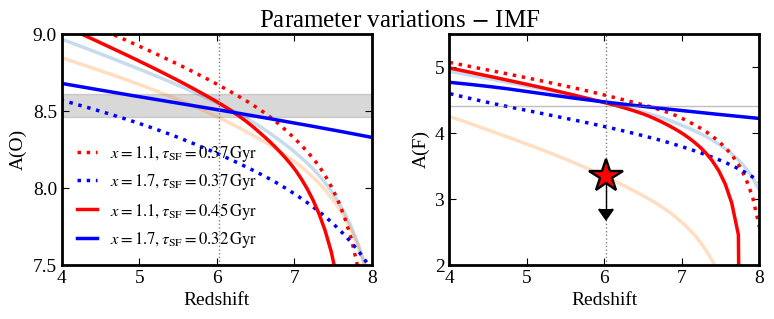

In [35]:
## New model

alpha = 0.25
lw = 2.5

fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.subplots_adjust(wspace=0.25)
ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('A(O)')

# Fiducial models
# ax[0].plot(z0, AO0, color='tab:blue', ls='--', alpha=alpha)
ax[0].plot(z3, AO3, color='tab:blue', ls='-', alpha=alpha, lw=lw)
# ax[0].plot(z2, AO2, color='tab:orange', ls='--', alpha=alpha)
ax[0].plot(z1, AO1, color='tab:orange', ls='-', alpha=alpha, lw=lw)

# 150 km/s model
# ax[0].plot(z8, AO8, color='black', ls='-', label="150 km/s")
# IMF (x=1.1) model
ax[0].plot(z4, AO4, color='red', ls='dotted', label=r"$x=1.1, \tau_{\rm SF}=0.37\,\mathrm{Gyr}$", lw=lw)
# IMF (x=1.7) model
ax[0].plot(z5, AO5, color='blue', ls='dotted', label=r"$x=1.7, \tau_{\rm SF}=0.37\,\mathrm{Gyr}$", lw=lw)
# IMF (x=1.1, tau=0.45) model
ax[0].plot(z9, AO9, color='red', ls='-', label=r"$x=1.1, \tau_{\rm SF}=0.45\,\mathrm{Gyr}$", lw=lw)
# IMF (x=1.7, tau=0.32) model
ax[0].plot(z10, AO10, color='blue', ls='-', label=r"$x=1.7, \tau_{\rm SF}=0.32\,\mathrm{Gyr}$", lw=lw)
ax[0].axvline(6.024, color='gray', ls=':', lw=1)

# G09の金属量範囲を帯で表示
ax[0].axhspan(Z_g09_low, Z_g09_upp, color='gray', alpha=0.3)
ax[0].legend()


ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('A(F)')

# Fiducial models
# ax[1].plot(z0, AF0, color='tab:orange', ls='--', alpha=alpha)
ax[1].plot(z1, AF1, color='tab:orange', ls='-', alpha=alpha, lw=lw)
# ax[1].plot(z2, AF2, color='tab:blue', ls='--', alpha=alpha)
ax[1].plot(z3, AF3, color='tab:blue', ls='-', alpha=alpha, lw=lw)

# 150 km/s model
# ax[1].plot(z4, AF4, color='black', ls='-')
# IMF (x=1.1) model
ax[1].plot(z4, AF4, color='red', ls='dotted', label=r"$x=1.1\,\mathrm{Gyr}$", lw=lw)
# IMF (x=1.7) model
ax[1].plot(z5, AF5, color='blue', ls='dotted', label=r"$x=1.7\,\mathrm{Gyr}$", lw=lw)
# IMF (x=1.1, tau=0.45) model
ax[1].plot(z9, AF9, color='red', ls='-', label=r"$x=1.1, \tau_{\rm SF}=0.45\,\mathrm{Gyr}$", lw=lw)
# IMF (x=1.7, tau=0.32) model
ax[1].plot(z10, AF10, color='blue', ls='-', label=r"$x=1.7, \tau_{\rm SF}=0.32\,\mathrm{Gyr}$", lw=lw)

# 観測結果 (上限値なので下向きに矢印、赤い丸を黒い縁取りで囲む)
ax[1].errorbar(
    x=6.024, y=12+HF_ratio, color='red',
    yerr=0.5, fmt='*', ecolor='black', elinewidth=1., capsize=5, markersize=25, mec='black', mew=1.7,
    barsabove=False, lolims=False, uplims=True, xlolims=False, xuplims=False, errorevery=1, capthick=None, zorder=4,
    )

# legend用 のダミー点
ax[1].scatter(
    x=[], y=[], color='red',
    marker='*', s=300, edgecolor='black', linewidth=1,
    label=r'This work ($5\sigma$ upper limit)'
    )


ax[1].plot([], [], color='black', ls='--')
ax[1].plot([], [], color='black', ls='-')

ax[1].axvline(6.024, color='gray', ls=':', lw=1)

ax[0].set_xlim(4,8)
ax[0].set_ylim(7.5, 9)
ax[1].set_xlim(4,8)
ax[1].set_ylim(2, 5.5)
# ax[1].legend()

# solar abundance
ax[1].axhline(4.4, color="gray", ls="-", alpha=0.5, lw=1) # Asplund et al. (2009) --> Maiorca et al. (2014) に合わせて4.56 --> 4.4に修正

fig.suptitle(r"Parameter variations $-$ IMF", fontsize=18, y=0.96)

fig.savefig("./fig/chemical_evolution_models_comparison3.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("saved ./fig/chemical_evolution_models_comparison3.pdf")

saved ./fig/chemical_evolution_models_comparison2.pdf


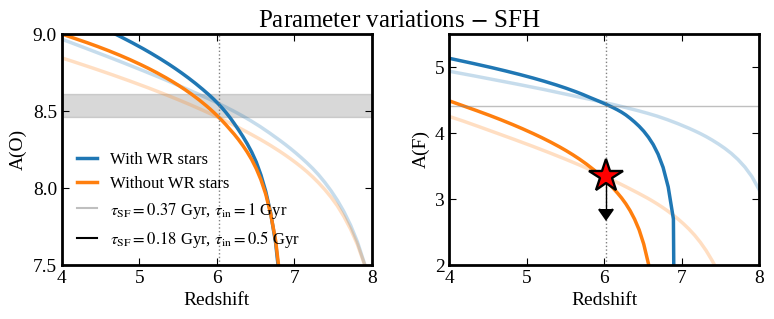

In [36]:
## New model

alpha = 0.25
lw = 2.5

fig, ax = plt.subplots(1, 2, figsize=(9,3))
fig.subplots_adjust(wspace=0.25)
ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('A(O)')

# Fiducial models
# ax[0].plot(z0, AO0, color='tab:blue', ls='--', alpha=alpha)
ax[0].plot(z3, AO3, color='tab:blue', ls='-', alpha=alpha, lw=lw)
# ax[0].plot(z2, AO2, color='tab:orange', ls='--', alpha=alpha)
ax[0].plot(z1, AO1, color='tab:orange', ls='-', alpha=alpha, lw=lw)

# tau_s=0.18 Gyr, tau_i=0.5 Gyr w/WR stars model
ax[0].plot(z6, AO6, color='tab:blue', ls='-', label="With WR stars", lw=lw)
# tau_s=0.18 Gyr, tau_i=0.5 Gyr w/o WR stars model
ax[0].plot(z7, AO7, color='tab:orange', ls='-', label="Without WR stars", lw=lw)

ax[0].plot([], [], color='black', ls='-', alpha=alpha, label=r'$\tau_{\rm SF}=0.37$ Gyr, $\tau_{\rm in}=1$ Gyr')
ax[0].plot([], [], color='black', ls='-', label=r'$\tau_{\rm SF}=0.18$ Gyr, $\tau_{\rm in}=0.5$ Gyr')
ax[0].axvline(6.024, color='gray', ls=':', lw=1)

# G09の金属量範囲を帯で表示
ax[0].axhspan(Z_g09_low, Z_g09_upp, color='gray', alpha=0.3)
ax[0].legend()


ax[1].set_xlabel('Redshift')
ax[1].set_ylabel('A(F)')

# Fiducial models
# ax[1].plot(z0, AF0, color='tab:orange', ls='--', alpha=alpha)
ax[1].plot(z1, AF1, color='tab:orange', ls='-', alpha=alpha, lw=lw)
# ax[1].plot(z2, AF2, color='tab:blue', ls='--', alpha=alpha)
ax[1].plot(z3, AF3, color='tab:blue', ls='-', alpha=alpha, lw=lw)

# tau_s=0.18 Gyr, tau_i=0.5 Gyr w/WR stars model
ax[1].plot(z6, AF6, color='tab:blue', ls='-', label=r"$\tau_{\rm SF}=0.18\,\mathrm{Gyr}, \tau_{\rm in}=0.5\,\mathrm{Gyr}$", lw=lw)
# tau_s=0.18 Gyr, tau_i=0.5 Gyr w/o WR stars model
ax[1].plot(z7, AF7, color='tab:orange', ls='-', label=r"$\tau_{\rm SF}=0.18\,\mathrm{Gyr}, \tau_{\rm in}=0.5\,\mathrm{Gyr}$", lw=lw)

# 観測結果 (上限値なので下向きに矢印、赤い丸を黒い縁取りで囲む)
ax[1].errorbar(
    x=6.024, y=12+HF_ratio, color='red',
    yerr=0.5, fmt='*', ecolor='black', elinewidth=1., capsize=5, markersize=25, mec='black', mew=1.7,
    barsabove=False, lolims=False, uplims=True, xlolims=False, xuplims=False, errorevery=1, capthick=None, zorder=4,
    )

# legend用 のダミー点
ax[1].scatter(
    x=[], y=[], color='red',
    marker='*', s=300, edgecolor='black', linewidth=1,
    label=r'This work ($5\sigma$ upper limit)'
    )


ax[1].plot([], [], color='black', ls='--')
ax[1].plot([], [], color='black', ls='-')

ax[1].axvline(6.024, color='gray', ls=':', lw=1)

ax[0].set_xlim(4,8)
ax[0].set_ylim(7.5, 9)
ax[1].set_xlim(4,8)
ax[1].set_ylim(2, 5.5)
# ax[1].legend()

# solar abundance
ax[1].axhline(4.4, color="gray", ls="-", alpha=0.5, lw=1) # Asplund et al. (2009) --> Maiorca et al. (2014) に合わせて4.56 --> 4.4に修正


fig.suptitle(r"Parameter variations $-$ SFH", fontsize=18, y=0.96)

fig.savefig("./fig/chemical_evolution_models_comparison2.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("saved ./fig/chemical_evolution_models_comparison2.pdf")

## N_HF - N_H2 plot

Figure saved to ./fig/NHF_NH2.pdf


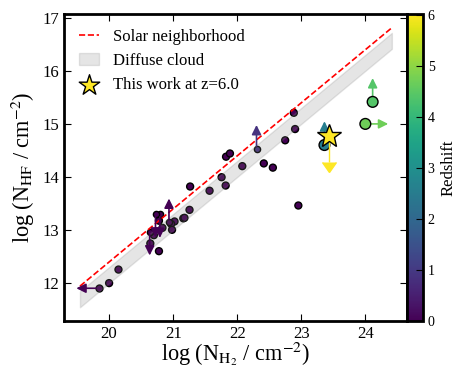

In [37]:
from matplotlib.lines import Line2D
import pandas as pd

# Load dataset
df = pd.read_csv('./HF_H2.csv')

fig, ax = plt.subplots(figsize=(5,4))

norm = plt.Normalize(0, 6.024)
cmap = plt.cm.viridis


# This work
ax.errorbar(
    x=np.log10(NH2.value),  # x
    y=np.log10(NHF),        # y
    yerr=0.5,               
    color=cmap(norm(6.024)),
    fmt='*', ecolor=cmap(norm(6.024)), elinewidth=1., capsize=5, markersize=18, mec='black', mew=1.,
    barsabove=False, lolims=False, uplims=True, xlolims=False, xuplims=False, errorevery=1, capthick=None, zorder=10,
)

# Plot detection points
mask_detection = (df['HF_limit']=='none') & (df['H2_limit']=='none')
sc = ax.scatter(df.loc[mask_detection, 'log_N_H2'], df.loc[mask_detection, 'log_N_HF'], c=df.loc[mask_detection, 'redshift'], cmap=cmap, norm=norm, s=25, edgecolor='black')

# high-z detectionは大きめに
mask_highz_detection = df['redshift'] >= 2.5
ax.scatter(df.loc[mask_highz_detection, 'log_N_H2'], df.loc[mask_highz_detection, 'log_N_HF'], c=df.loc[mask_highz_detection, 'redshift'], cmap=cmap, norm=norm, s=60, edgecolor='black', marker='o', zorder=5)

# Plot H2 limits
for idx, row in df.iterrows():
    x=row['log_N_H2']; y=row['log_N_HF']; z=row['redshift']
    if row['H2_limit'] in ['upper','lower']:
        color = cmap(norm(z))
        ax.scatter(x, y, c=[z], cmap=cmap, norm=norm, marker='o', edgecolor='black', s=25)
        if row['H2_limit']=='upper':
            ax.annotate('', xy=(x-0.4, y), xytext=(x, y), arrowprops=dict(arrowstyle='-|>', lw=1.2, color=color))
        else:
            ax.annotate('', xy=(x+0.4, y), xytext=(x, y), arrowprops=dict(arrowstyle='-|>', lw=1.2, color=color))

# Plot HF limits (lower and upper), with this work colored according to redshift
for idx, row in df.iterrows():
    x=row['log_N_H2']; y=row['log_N_HF']; z=row['redshift']
    is_thiswork = 'This work' in str(row['Object'])
    color = cmap(norm(z))
    if row['HF_limit']=='lower':
        ax.scatter(x, y, c=[z], cmap=cmap, norm=norm, marker='o', edgecolor='black', s=20)
        ax.annotate('', xy=(x, y+0.5), xytext=(x, y), arrowprops=dict(arrowstyle='-|>', lw=1.2, color=color))
    elif row['HF_limit']=='upper':
        if is_thiswork:
            # Use colormap color for this star
            ax.scatter(x, y, marker='*', s=240, color=[color], edgecolor='black', zorder=6)
            ax.annotate('', xy=(x, y-0.5), xytext=(x, y), arrowprops=dict(arrowstyle='-|>', lw=1.4, color=color))
        else:
            ax.scatter(x, y, c=[z], cmap=cmap, norm=norm, marker='o', edgecolor='black', s=20)
            ax.annotate('', xy=(x, y-0.5), xytext=(x, y), arrowprops=dict(arrowstyle='-|>', lw=1.2, color=color))

# Ratio lines
x_vals = np.linspace(df['log_N_H2'].min()-0.3, df['log_N_H2'].max()+0.3, 100)
ratio_solar=2.5e-8 # Solar neighborhood Asplund et al. (2009) --> Maiorca et al. (2014) に合わせて3.6e-8 --> 2.5e-8に修正
ratio_diffuse_low=1e-8
ratio_diffuse_upp=2e-8
ax.plot(x_vals, np.log10(ratio_solar)+x_vals, linestyle='--', color='red', linewidth=1.2, label='Solar neighborhood')
# ax.plot(x_vals, np.log10(ratio_diffuse)+x_vals, linestyle=':', color='black', linewidth=1.2, label='Diffuse cloud')
ax.fill_between(x_vals, np.log10(ratio_diffuse_low)+x_vals, np.log10(ratio_diffuse_upp)+x_vals, color='gray', alpha=0.2, label='Diffuse cloud')

ax.set_xlabel('log (N$_{\mathrm{H_2}}$ / cm$^{-2}$)', fontsize=16, labelpad=-1)
ax.set_ylabel('log (N$_{\mathrm{HF}}$ / cm$^{-2}$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)


# Colorbar
cbar = fig.colorbar(sc, ax=ax, pad=0.0)
cbar.set_label('Redshift', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Dummy star for this work in legend
z_this = 6.02
star_color = cmap(norm(z_this))
ax.scatter([], [], marker='*', s=240, color=[star_color], edgecolor='black', label='This work at z=6.0')

ax.legend()

fig.tight_layout()

# save figure
fig.savefig("./fig/NHF_NH2.pdf", dpi=200, pad_inches=.05, bbox_inches='tight')
print("Figure saved to ./fig/NHF_NH2.pdf")